In [59]:
import numpy as np
import pandas as pd
import datetime
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import catboost as catb
import lightgbm as lgbm
from imblearn.over_sampling import RandomOverSampler, ADASYN, BorderlineSMOTE


from scipy.stats import shapiro, probplot, ttest_ind, mannwhitneyu, chi2_contingency
from statsmodels.stats.weightstats import zconfint

import seaborn as sns
import warnings
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5


warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
plt.style.use('seaborn-whitegrid')

## Загрузим сохраненные после обработки датасеты

In [213]:
df_train = pd.read_csv('df_final.csv', sep=',')
df_test = pd.read_csv('df_test_final.csv', sep=',')

In [214]:
df_train.shape

(7500, 18)

In [215]:
y = df_train[target_feat]
X = df_train.drop(target_feat, axis=1)
X.shape

(7500, 17)

In [216]:
X = pd.get_dummies(X)
X_valid = pd.get_dummies(df_test)
feature_names = X.columns

In [229]:
for col in X.columns:
    if col not in X_valid.columns:
        X_valid[col] = 0
        print(col)

Purpose_renewable energy


In [230]:
X_valid.shape

(2500, 34)

In [231]:
X.shape

(7500, 34)

In [220]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 33):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, 1.3, 1, 2])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

## Создадим модель Случайного леса с балансировкой классов с оптимальными параметрами на всем датасете

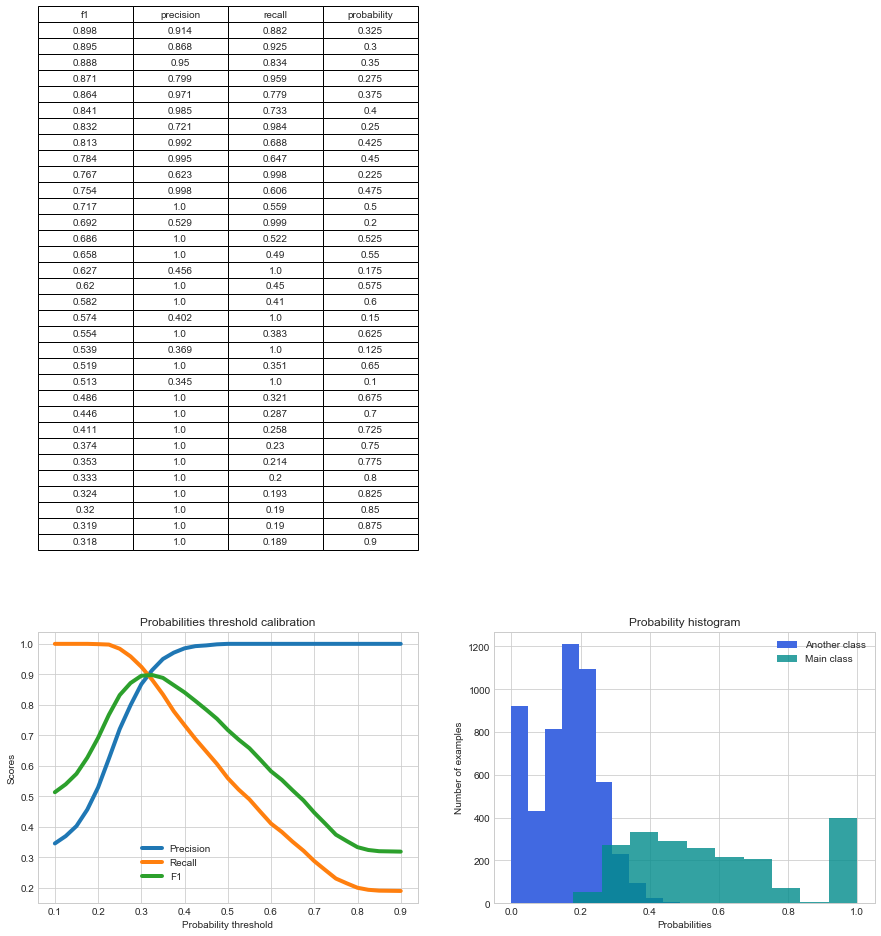

In [223]:
clf = RandomForestClassifier(max_depth=14, 
                             max_features=14,
                             n_estimators=500, 
                             criterion='entropy'
                            )
clf.fit(X, y)
y_pred_probs = clf.predict_proba(X)
show_proba_calibration_plots(y_pred_probs[:, 1], y)

Для порога предсказания выберем вероятность 0.325

In [250]:
y_valid_pred_probs = clf.predict_proba(X_valid)

In [253]:
class_pred = y_valid_pred_probs[:, 1]>0.325
np.count_nonzero(class_pred)

695

In [254]:
df_test['Credit Deafault pred'] = class_pred
df_test['Credit Deafault pred'] = df_test['Credit Deafault pred'].map({True: 1, False:0})

In [255]:
df_test.head()

,Home Ownership,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Job_years,Score_level,Max_open_credit_level,Credit Deafault pred
0,Rent,1.188935e+06,0.0,9.0,12.5,220968.0,0.0,0.0,debt consolidation,1,162470.0,105906.0,6813.0,1309.402235,4.0,0,0,0
1,Rent,2.318380e+05,0.0,6.0,32.7,55946.0,0.0,0.0,educational expenses,1,78298.0,46037.0,2318.0,699.000000,1.0,0,0,1
2,Home Mortgage,1.152540e+06,0.0,10.0,13.7,204600.0,0.0,0.0,debt consolidation,1,200178.0,146490.0,18729.0,7260.000000,3.0,1,0,1
3,Home Mortgage,1.220313e+06,0.0,16.0,17.0,456302.0,0.0,0.0,debt consolidation,1,217382.0,213199.0,27559.0,739.000000,10.0,0,0,0
4,Home Mortgage,2.340952e+06,0.0,11.0,23.6,1207272.0,0.0,0.0,debt consolidation,0,777634.0,425391.0,42605.0,706.000000,6.0,0,0,0


In [256]:
df_test.to_csv("IskenderovR_predictions.csv", sep=",", index=False)